In [29]:
import numpy as np
import pandas as pd
import networkx as nx
import os, random
SEED = 2
random.seed(SEED)

In [30]:
%pip install shapely

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [31]:
players_graph = nx.read_gml(os.path.join('comm-f2f-Resistance', 'embeddings.gml'))

In [32]:
communities = nx.community.greedy_modularity_communities(players_graph, weight='weight', resolution=1.5, best_n=4)
[len(community) for community in communities]

[131, 130, 104, 86]

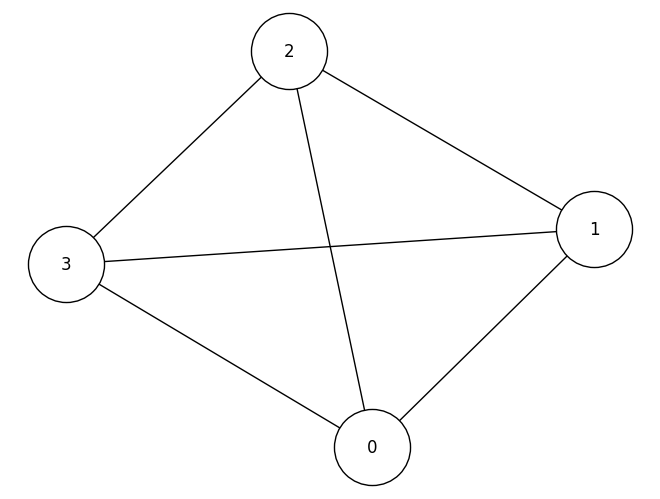

In [33]:
# First we create a new graph collapsing communities as nodes
from statistics import mean
collapsed_communities = nx.Graph()
for i in range(len(communities)):
    collapsed_communities.add_node(i)
    
node_to_community = {}
for i, community in enumerate(communities):
    for node in community:
        node_to_community[node] = i
    
all_relationships = {}
for idx, community in enumerate(communities):
    relationships = {}
    for node in community:
        for edge in players_graph.edges(node, data=True):
            other_community = node_to_community[edge[1]]
            if other_community != idx:
                relationships.setdefault(other_community, []).append(edge[2]['weight'])
    all_relationships[idx] = relationships
    
counted = set()
for community, relationships in all_relationships.items():       
    for other_community, weights in relationships.items():
        if other_community not in counted:
            weight = (mean(weights) + mean(all_relationships[other_community].get(community, []))) / 2
            collapsed_communities.add_edge(community, other_community, weight=weight)
    counted.add(community)
nx.draw(collapsed_communities, node_color='white', edgecolors='black', edge_color='black', node_size=3000, with_labels=True)

In [34]:
for edge in players_graph.edges(data=True):
    data = edge[2]
    # We use this extreme of a factor to emphasize subcommunities inside 
    # communities and the offset is to avoid very far nodes
    data['edge_size'] = data['weight']**20*20+0.005

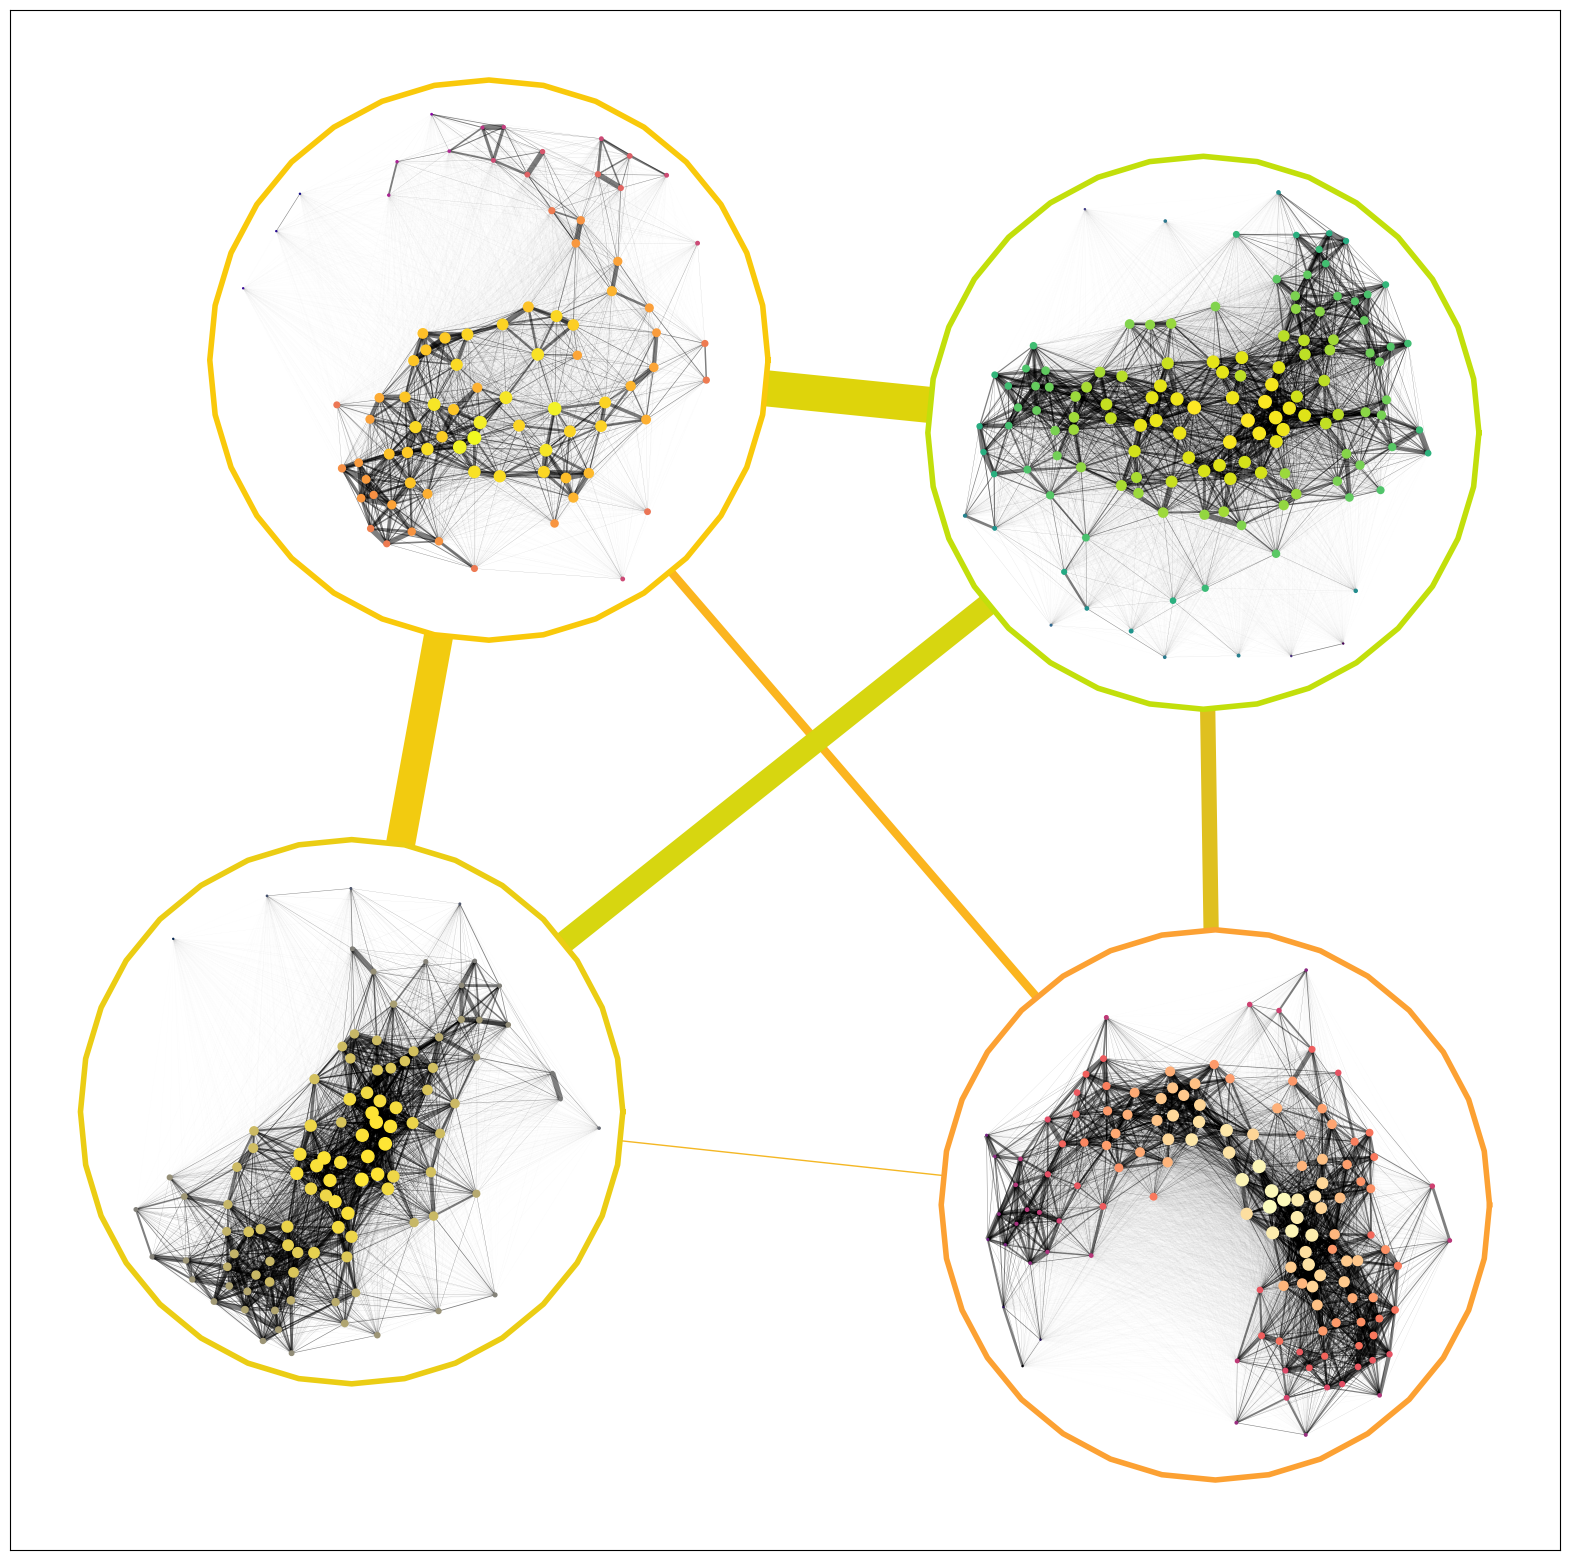

In [ ]:
import colorsys
from matplotlib import colormaps
import matplotlib.pyplot as plt
from shapely import minimum_bounding_circle, MultiPoint
plt.figure(figsize=(20, 20))

community_cms = [
    colormaps['magma'],
    colormaps['viridis'],
    colormaps['cividis'],
    colormaps['plasma']
]

community_centers = nx.spring_layout(collapsed_communities, weight='weight', seed=SEED, iterations=1000)

def scale(values):
    return [(value - min(values)) / (max(values) - min(values)) for value in values]

def expand_bounding_circle(mbc, distance):
    cx = mbc.centroid.xy[0][-1]
    cy = mbc.centroid.xy[1][-1]
    coords = [[],[]]
    for x, y in zip(*mbc.exterior.xy):
        m = (y - cy)/(x - cx) if x != cx else None
        radius = ((y - cy)**2 + (x - cx)**2)**0.5
        if m is None:
            y_r = (radius + distance) * (((y - cy) > 0)*2 - 1)
            x_r = 0
        else:
            x_r = (radius + distance)/(1 + m**2)**0.5 * (((x - cx) > 0)*2 - 1)
            y_r = x_r*m
            
        x2 = x_r + cx
        y2 = y_r + cy
        coords[0].append(x2)
        coords[1].append(y2)
    return coords

communities_final_color = {}
for i, community in enumerate(communities):
    cm = community_cms[i]
    G = players_graph.subgraph(community)
    pos = nx.spring_layout(G,weight='edge_size', seed=SEED, iterations=1000)
    pos = {
        node:(x, y) 
        for node, x, y in zip(
            G.nodes,
            scale([pos[node][0] for node in G.nodes]),
            scale([pos[node][1] for node in G.nodes])
        )
    }
    
    mbc = minimum_bounding_circle(MultiPoint([*pos.values()]))
    cx = mbc.centroid.xy[0][-1]
    cy = mbc.centroid.xy[1][-1]
    pos = {node: (pos[node][0] + community_centers[i][0] - cx, pos[node][1] + community_centers[i][1] - cy) for node in G.nodes()}

    weights = [min(G[u][v]['edge_size'], 4) for u,v in G.edges()]
    node_degrees = [G.degree(node, weight='weight') for node in G.nodes()]
    nodes_color = cm(scale(node_degrees))
    node_sizes = [(degree*3)**4+0.5 for degree in scale(node_degrees)]
    nx.draw_networkx_nodes(G, pos=pos, node_color=nodes_color, node_size=node_sizes)
    nx.draw_networkx_edges(G, pos=pos, width=weights, edge_color='black', alpha=0.5)
    
    # Calculate color average for the bounding circle
    # Weighted by the square of the size because it should be proportional to the area
    total_size_sq = sum(size**2 for size in node_sizes)
    color_avg = sum([color * size**2/total_size_sq for color, size in zip(nodes_color, node_sizes)])
    color_avg[color_avg > 1] = 1
    color_avg[color_avg < 0] = 0
    # Increase saturation
    h, s, v = colorsys.rgb_to_hsv(color_avg[0], color_avg[1], color_avg[2])
    r, g, b = colorsys.hsv_to_rgb(h, s**0.25, v)
    a = color_avg[3]
    communities_final_color[i] = np.array((r, g, b, a))
        
    # Draw the community
    embc = expand_bounding_circle(mbc, 0.05)
    embc = [[x + community_centers[i][0] - cx for x in embc[0]], [y + community_centers[i][1] - cy for y in embc[1]]]
    plt.fill(*embc, color='white', zorder=0)
    plt.plot(*embc, color=(r,g,b,a), alpha=1, linewidth=4, label=f'Community {(i+1)}')
    plt.axis('equal')

# The weights are ranked in order of the most simmilarity between communities
weights = (pd.Series([collapsed_communities[u][v]['weight'] for u,v in collapsed_communities.edges()]).rank().astype(int).values - 1) * 5 + 1
colors = [(communities_final_color[i] + communities_final_color[j])/2 for i,j in collapsed_communities.edges()]
nx.draw_networkx_edges(collapsed_communities, pos=community_centers, width=weights, edge_color=colors, alpha=1).set_zorder(-1)